# Tôi tự học Keras

## Bài 8: Mô hình Auto-encoder : Phát hiện bất thường trên dữ liệu chuỗi

### Lê Ngọc Khả Nhi

### 22/11/2018

Chào các bạn, trong bài thực hành thứ 8 của chuỗi bài "Tôi tự học Keras", chúng ta sẽ cùng tìm hiểu về mô hình Auto-encoder và một trong các ứng dụng của nó là để phát hiện diễn biến bất thường trong dữ liệu chuỗi.

Trước khi khởi hành, Nhi sẽ giúp các bạn tăng hứng thú và động lực bằng việc giải thích về những ứng dụng của bài toán phát hiện diễn tiến bất thường vào nghiên cứu y học. Trong một số hoàn cảnh, chúng ta theo dõi diễn tiến của một đại lượng trong một khoảng thời gian dài và muốn  thiết lập một mô hình có khả năng tự động phát hiện sự thay đổi bất thường của đại lượng này. Một số thí dụ như:

1) Báo động sự cố ngừng tim, loạn nhịp, suy hô hấp, tụt huyết áp... ở bệnh nhân đang được theo dõi tại khoa hồi sức tích cực hay trong khi phẫu thuật

2) Phát hiện tai nạn té ngã của bệnh nhân tại phòng bệnh hay người già yếu tại nhà, nhờ cảm biến gia tốc.

3) Phát hiện sớm đợt kịch phát của bệnh hen, COPD, đợt tăng huyết áp ... nhờ theo dõi một biomarker.

4) Cảnh báo sự thay đổi mức độ ô nhiễm không khí, rò rỉ khí độc... 

Về mặt kỹ thuật, phát hiện bất thường trên dữ liệu chuỗi (Anomaly detection) là một bài toán unsupervised learning, đã có rất nhiều giải pháp từng được giới thiệu, từ thô sơ cho đến phức tạp. Trong bài này, chúng ta sẽ giải quyết bài toán bằng các mô hình Autoencoder với keras. 

Auto-encoder là một mô hình mạng neuron đặc biệt, với mục tiêu là tái hiện lại dữ liệu đầu vào chính xác nhất có thể. Như vậy, nếu ta huấn luyện thành công một auto-encoder trên những dữ liệu được xem là "bình thường", ta có thể dùng kết quả đầu ra của mô hình làm mốc so sánh với dữ liệu mới cần chẩn đoán. Nếu khác biệt này cao hơn 1 ngưỡng do ta quy định, dữ liệu mới sẽ được xem là bất thường. 

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler

from keras.layers import *
from keras.models import *

Using TensorFlow backend.


Trong thư mục hiện hành, có file anomaly.csv, chứa 28 đoạn dữ liệu mô phỏng với độ dài 100. Bạn có thể hình dung đây là một đoạn tín hiệu dài 10 giây với tần số lấy mẫu là 10 Hz. Dùng hàm read_csv để tải dữ liệu và lưu lại dưới object có tên là sample, ta sẽ thấy sample là 1 dataframe 28 hàng và 100 cột, mỗi cột là 1 mẫu, mỗi hàng là 1 chu kỳ quan sát. 

In [2]:
sample = pd.read_csv('anomaly.csv', header=None,sep=',')

print(sample.shape)
sample.head()

(28, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.060888,0.860444,0.093975,0.124248,0.940973,0.295047,-0.593885,-0.296089,-0.171869,0.688101,...,0.340102,0.180615,-0.265730,0.758439,-0.251491,1.184205,0.847003,-0.063732,-0.470978,-0.308220
1,-0.155012,-0.219611,-0.606550,-0.025836,-0.499762,-1.065388,-0.240547,0.591666,-0.365530,0.392435,...,0.063591,-0.570516,-0.836623,1.282314,0.387788,-0.798491,-0.388474,-0.756349,1.411446,0.843667
2,0.293160,-0.241316,-0.275871,-0.450221,-0.341943,0.911463,-0.040197,0.056521,0.125982,0.677903,...,-0.332370,1.107705,0.027192,1.031999,-0.764086,0.001673,0.687637,-0.409273,-0.430175,-0.533913
3,-0.135900,0.216393,-0.858998,0.161739,0.631575,0.998797,0.661149,0.411534,-0.727185,-0.211255,...,-0.198441,0.754101,-0.290412,0.452322,-0.513496,-0.098019,0.030817,-0.471298,-0.226497,0.051319
4,-1.121058,-0.211131,0.562647,-0.343378,0.192523,0.377850,0.220883,0.490493,-0.052309,-0.255846,...,-0.916472,0.160733,0.148837,0.288233,0.419772,-0.387506,-0.661581,0.751782,0.558908,-1.022160


20 đoạn đầu tiên được xem như "bình thường", giá trị của chúng được tạo ra bằng một hàm random với trung bình = 0 và sd=1. Trong biểu đồ dưới đây, bạn sẽ thấy hình ảnh của 20 chuỗi dữ liệu chồng lên nhau: vị trí trung tâm = 0 và biên độ dao động từ -1 đến +1. 

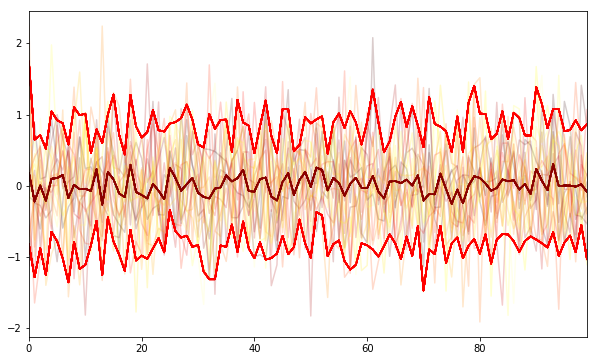

In [3]:
colors=sns.color_palette("hot",20)
colpal=colors.as_hex()

plt.figure(figsize=(10,6))

# 20 mẫu đầu tiên được xem như trạng thái bình thường, và sẽ được dùng như training data

for i in range(0,19):
    sns.tsplot(sample.as_matrix()[i],color=colpal[i],alpha=0.2)
    sns.tsplot(sample.iloc[:19].mean(axis=0),color="darkred")
    sns.tsplot(sample.iloc[:19].quantile([0.05,0.95],axis=0).as_matrix()[0],color="red")
    sns.tsplot(sample.iloc[:19].quantile([0.05,0.95],axis=0).as_matrix()[1],color="red")

Còn đây là hình ảnh riêng biệt của từng chuỗi trong số 20 chuỗi bình thường này:

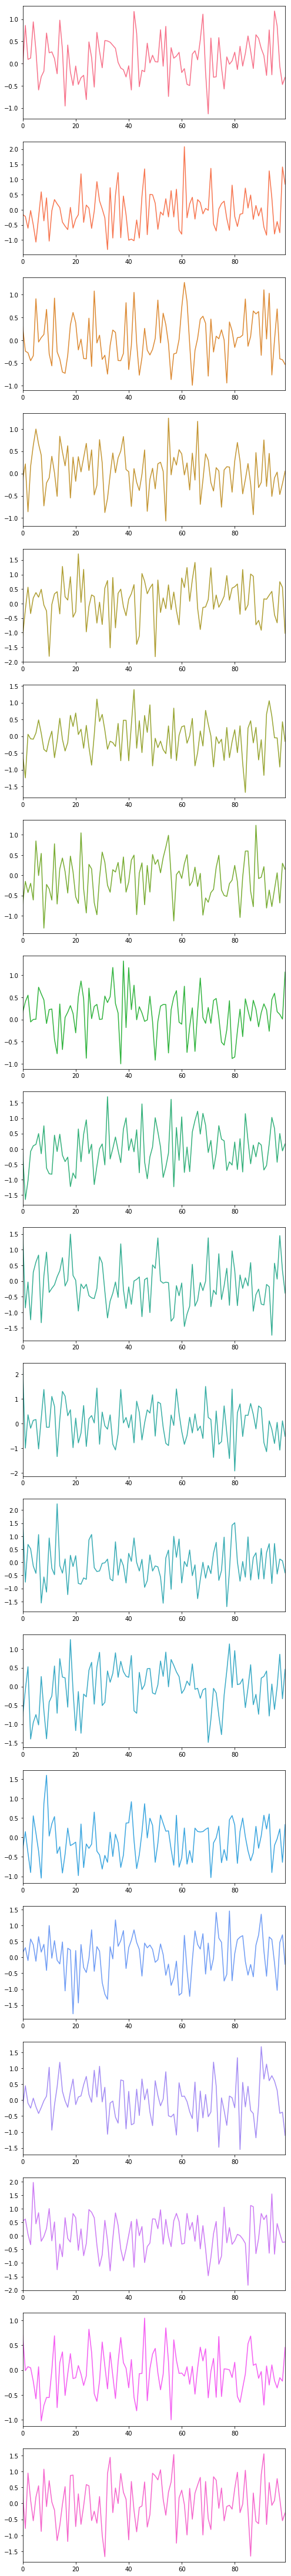

In [4]:
colors=sns.color_palette("husl",20)
colpal=colors.as_hex()

plt.figure(figsize=(8,80))

for i in range(0,19):
    plt.subplot(19,1,i+1)
    sns.tsplot(sample.as_matrix()[i],color=colpal[i])

Mật độ phân bố của 20 chuỗi có hình ảnh đồng dạng, với trung vị = 0 và tuân theo quy luật phân bố Gaussian.

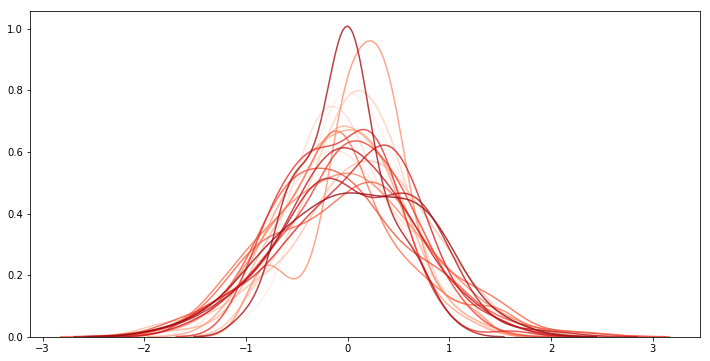

In [5]:
colors=sns.color_palette("Reds",20)
colpal=colors.as_hex()

plt.figure(figsize=(12,6))

for i in range(0,19):
    sns.kdeplot(sample.as_matrix()[i],color=colpal[i],alpha=0.8)

Một trong những khó khăn của bài toán phát hiện bất thường, đó là định nghĩa: thế nào là bất thường ? Có thể là sự thay đổi về tần số ? hay về biên độ ? 8 biểu đồ sau đây trình bày hình dạng của 8 chuỗi dữ liệu bất thường khác nhau, bao gồm : sự tăng/giảm đột ngột (diễn ra trong thời gian ngắn), sự tăng/giảm một cách tuyến tính, sự thay đổi trung bình/trung vị kéo dài, hoặc sự thay đổi về phương sai nhưng trung vị được bảo tồn... 

## Bất thường do tăng đột ngột

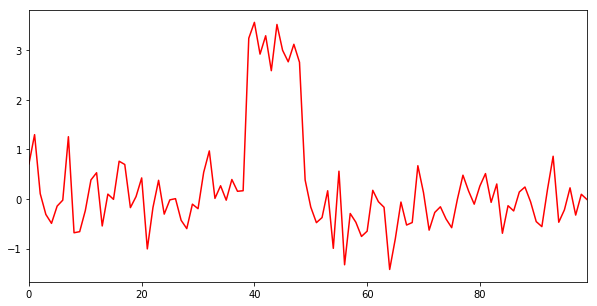

In [6]:
plt.figure(figsize=(10,5))
sns.tsplot(sample.as_matrix()[20],color="red")

## Bất thường do giảm đột ngột

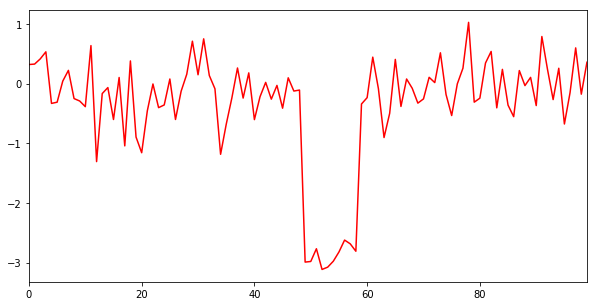

In [7]:
plt.figure(figsize=(10,5))
sns.tsplot(sample.as_matrix()[21],color="red")

## Bất thường : tăng tuyến tính

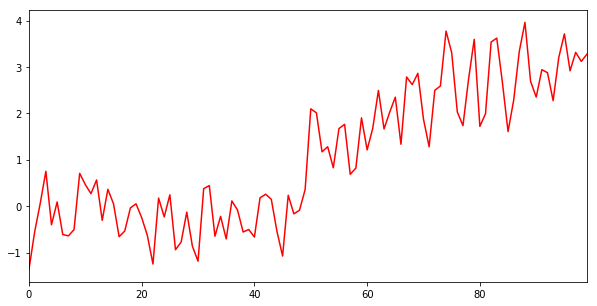

In [8]:
plt.figure(figsize=(10,5))
sns.tsplot(sample.as_matrix()[22],color="red")

## Bất thường: giảm tuyến tính

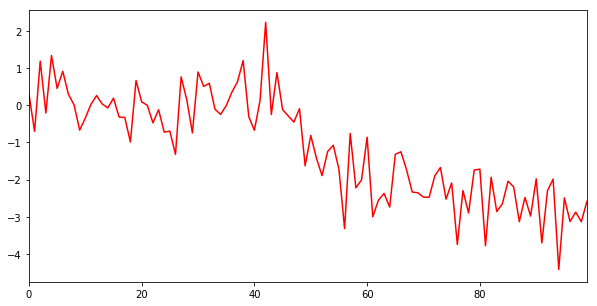

In [9]:
plt.figure(figsize=(10,5))
sns.tsplot(sample.as_matrix()[23],color="red")

## Bất thường: tăng trung vị

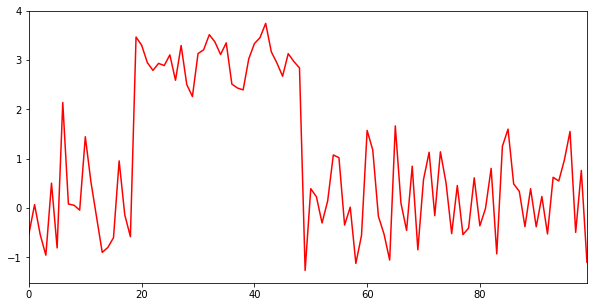

In [10]:
plt.figure(figsize=(10,5))
sns.tsplot(sample.as_matrix()[24],color="red")

## Bất thường: giảm trung vị

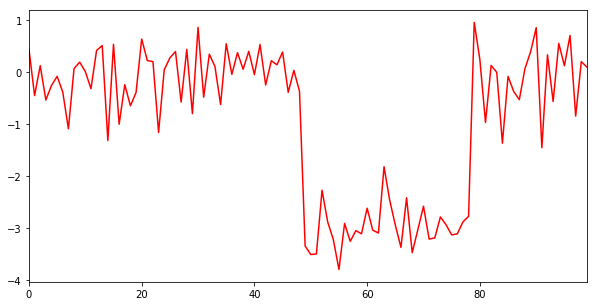

In [11]:
plt.figure(figsize=(10,5))
sns.tsplot(sample.as_matrix()[25],color="red")

## Bất thường: Tăng phương sai

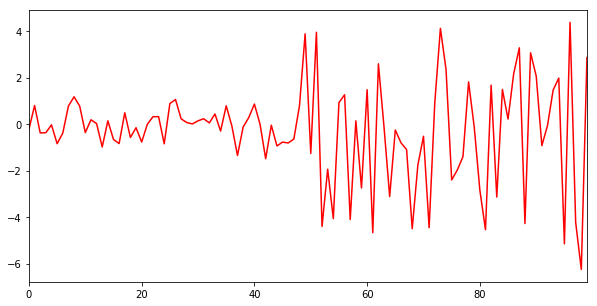

In [12]:
plt.figure(figsize=(10,5))
sns.tsplot(sample.as_matrix()[26],color="red")

## Bất thường: Giảm phương sai

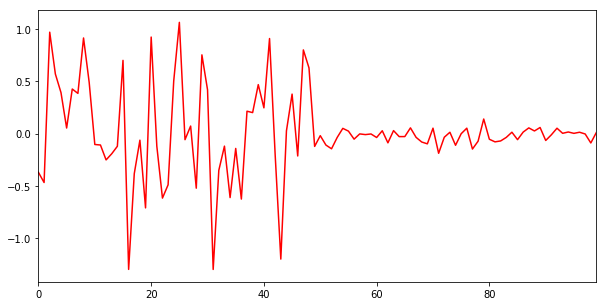

In [13]:
plt.figure(figsize=(10,5))
sns.tsplot(sample.as_matrix()[27],color="red")

Ta bắt đầu xây dựng mô hình: Trước hết, ta cần 1 hàm để chuẩn hóa dữ liệu. Trainset chỉ chứa các đoạn dữ liệu bình thường (20 đoạn đầu tiên), testset bao gồm 28 đoạn trong đó có 20 đoạn đầu bình thường và 8 đoạn sau là bất thường.

In [14]:
def data_prepare(trainset,testset):
    scaler=StandardScaler().fit(trainset)
    train_set = scaler.transform(trainset)
    test_set = scaler.transform(testset)
    input_data = np.expand_dims(trainset, axis=2)
    return train_set,test_set,input_data

In [15]:
train_set,test_set,input_data = data_prepare(sample.iloc[:20], sample.iloc[:28])

In [16]:
train_set.shape

(20, 100)

In [17]:
test_set.shape

(28, 100)

In [18]:
input_data.shape

(20, 100, 1)

# Mô hình auto-encoder LSTM

Hàm sau đây tạo ra 1 mô hình auto-encoder dựa vào LSTM algorithm. Bộ phận chính của mô hình là 1 lớp LSTM với 128 neurons, kio&ch thước đầu vào được xác định tự động, đầu ra của mô hình là 1 lớp Dense, kết quả là 1 tensor cùng kích thước với dữ liệu đầu vào, kích hoạt bằng hàm linear. 

In [19]:
def create_LSTM_autoencoder(input_data):
    window_size = input_data.shape[1]
    dim = input_data.shape[2]
    
    entry = Input(shape=(window_size,dim))
    lstm = LSTM(units=128, return_sequences=False)(entry)
    outcome = Dense(units=window_size,activation='linear')(lstm)
    
    model = Model(entry,outcome)
    model.compile(optimizer='adam', loss='mean_squared_error')

    print(model.summary())
    
    return model

In [21]:
model_lstm = create_LSTM_autoencoder(input_data)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 1)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               12900     
Total params: 79,460
Trainable params: 79,460
Non-trainable params: 0
_________________________________________________________________
None


# Mô hình auto-encoder 1D CNN

Mô hình auto-encoder thứ 2 có thể thử, sử dụng cấu trúc mạng neuron CNN 1 chiều: dữ liệu đầu vào đi qua 1 lớp Convolution 1D, sau đó là 1 lớp GlobalMaxPool1D và cuối cùng là 1 lớp Dense để xuất kết quả.


In [20]:
def create_1DCNN_autoencoder(input_data):
    window_size = input_data.shape[1]
    dim = input_data.shape[2]
    
    entry = Input(shape=(window_size,dim))
    conv = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(entry)
    pool = GlobalMaxPool1D()(conv)
    outcome = Dense(units=window_size,activation='linear')(pool)
    
    model = Model(entry,outcome)
    model.compile(optimizer='adam', loss='mean_squared_error')

    print(model.summary())
    
    return model

In [22]:
model_1DCNN = create_1DCNN_autoencoder(input_data)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 256)          1024      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25700     
Total params: 26,724
Trainable params: 26,724
Non-trainable params: 0
_________________________________________________________________
None


# Mô hình auto_encoder lai CNN và LSTM

Ta có thể kết hợp CNN và LSTM trong cùng một mô hình, bộ phận CNN trích xuất features để làm dữ liệu đầu vào cho lớp LSTM, cuối cùng là lớp Dense để xuất kết quả:

In [23]:
def create_Hybrid_autoencoder(input_data):
    window_size = input_data.shape[1]
    dim = input_data.shape[2]
    
    entry = Input(shape=(window_size,dim))
    conv = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(entry)
    pool = MaxPooling1D(pool_size=4)(conv)
    lstm = LSTM(64)(pool)
    outcome = Dense(units=window_size,activation='linear')(lstm)
    
    model = Model(entry,outcome)
    model.compile(optimizer='adam', loss='mean_squared_error')

    print(model.summary())
    
    return model

In [24]:
model_hybrid = create_Hybrid_autoencoder(input_data)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 1)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 256)          1024      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               6500      
Total params: 89,700
Trainable params: 89,700
Non-trainable params: 0
_________________________________________________________________
None


# Mô hình Auto-encoder LSTM 2 chiều

Cuối cùng, ta có thể thử algorithm LSTM 2 chiều bằng cách đặt lớp LSTM vào trong hàm Bidirectional

In [25]:
def create_Bidirection_autoencoder(input_data):
    window_size = input_data.shape[1]
    dim = input_data.shape[2]
    
    model = Sequential()
    model.add(Bidirectional(LSTM(units=256, dropout=0.2, 
                                 recurrent_dropout=0.2), 
                            input_shape=(window_size,dim)
                           )
             )
    model.add(Dense(units=window_size, 
                    activation='linear'))
    model.compile(optimizer='adam', 
                  loss='mean_squared_error')

    print(model.summary())
    
    return model

In [26]:
model_Bidir = create_Bidirection_autoencoder(input_data)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 512)               528384    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               51300     
Total params: 579,684
Trainable params: 579,684
Non-trainable params: 0
_________________________________________________________________
None


# Huấn luyện 4 mô hình

Ta lần lượt huấn luyện 4 mô hình ở trên, sử dụng ngẫu nhiên 60% từ 20 đoạn và kiểm định trên 40% đoạn còn lại.

In [27]:
model_lstm.fit(x=input_data,
               y=train_set,
               batch_size=10, 
               epochs=30,
               verbose=1,
               validation_split=0.4)

Train on 12 samples, validate on 8 samples
Epoch 1/30
12/12 [==============================] - 2s 203ms/step - loss: 0.9926 - val_loss: 1.0129
Epoch 2/30
12/12 [==============================] - 0s 33ms/step - loss: 0.9904 - val_loss: 1.0135
Epoch 3/30
12/12 [==============================] - 0s 33ms/step - loss: 0.9881 - val_loss: 1.0142
Epoch 4/30
12/12 [==============================] - 0s 33ms/step - loss: 0.9860 - val_loss: 1.0149
Epoch 5/30
12/12 [==============================] - 0s 33ms/step - loss: 0.9838 - val_loss: 1.0157
Epoch 6/30
12/12 [==============================] - 0s 34ms/step - loss: 0.9814 - val_loss: 1.0166
Epoch 7/30
12/12 [==============================] - 0s 35ms/step - loss: 0.9786 - val_loss: 1.0175
Epoch 8/30
12/12 [==============================] - 0s 33ms/step - loss: 0.9755 - val_loss: 1.0184
Epoch 9/30
12/12 [==============================] - 0s 33ms/step - loss: 0.9720 - val_loss: 1.0196
Epoch 10/30
12/12 [==============================] - 0s 34ms/step

In [29]:
model_1DCNN.fit(x=input_data,
               y=train_set,
               batch_size=10, 
               epochs=30,
               verbose=1,
               validation_split=0.4)

Train on 12 samples, validate on 8 samples
Epoch 1/30
12/12 [==============================] - 0s 0us/step - loss: 0.9320 - val_loss: 1.2257
Epoch 2/30
12/12 [==============================] - 0s 0us/step - loss: 0.9318 - val_loss: 1.2223
Epoch 3/30
12/12 [==============================] - 0s 1ms/step - loss: 0.9301 - val_loss: 1.2187
Epoch 4/30
12/12 [==============================] - 0s 1ms/step - loss: 0.9301 - val_loss: 1.2163
Epoch 5/30
12/12 [==============================] - 0s 1ms/step - loss: 0.9284 - val_loss: 1.2151
Epoch 6/30
12/12 [==============================] - 0s 0us/step - loss: 0.9272 - val_loss: 1.2126
Epoch 7/30
12/12 [==============================] - 0s 1ms/step - loss: 0.9257 - val_loss: 1.2096
Epoch 8/30
12/12 [==============================] - 0s 1ms/step - loss: 0.9250 - val_loss: 1.2080
Epoch 9/30
12/12 [==============================] - 0s 0us/step - loss: 0.9242 - val_loss: 1.2088
Epoch 10/30
12/12 [==============================] - 0s 1ms/step - loss: 0.

In [30]:
model_hybrid.fit(x=input_data,
               y=train_set,
               batch_size=10, 
               epochs=30,
               verbose=1,
               validation_split=0.4)

Train on 12 samples, validate on 8 samples
Epoch 1/30
12/12 [==============================] - 1s 81ms/step - loss: 0.9953 - val_loss: 1.0207
Epoch 2/30
12/12 [==============================] - 0s 9ms/step - loss: 0.9885 - val_loss: 1.0270
Epoch 3/30
12/12 [==============================] - 0s 9ms/step - loss: 0.9833 - val_loss: 1.0339
Epoch 4/30
12/12 [==============================] - 0s 9ms/step - loss: 0.9803 - val_loss: 1.0428
Epoch 5/30
12/12 [==============================] - 0s 9ms/step - loss: 0.9768 - val_loss: 1.0536
Epoch 6/30
12/12 [==============================] - 0s 10ms/step - loss: 0.9728 - val_loss: 1.0667
Epoch 7/30
12/12 [==============================] - 0s 9ms/step - loss: 0.9686 - val_loss: 1.0823
Epoch 8/30
12/12 [==============================] - 0s 10ms/step - loss: 0.9653 - val_loss: 1.1009
Epoch 9/30
12/12 [==============================] - 0s 9ms/step - loss: 0.9637 - val_loss: 1.1190
Epoch 10/30
12/12 [==============================] - 0s 9ms/step - loss:

In [31]:
model_Bidir.fit(x=input_data,
               y=train_set,
               batch_size=10, 
               epochs=20,
               verbose=1,
               validation_split=0.4)

Train on 12 samples, validate on 8 samples
Epoch 1/20
12/12 [==============================] - 2s 191ms/step - loss: 0.9932 - val_loss: 1.0130
Epoch 2/20
12/12 [==============================] - 1s 53ms/step - loss: 0.9878 - val_loss: 1.0137
Epoch 3/20
12/12 [==============================] - 1s 59ms/step - loss: 0.9827 - val_loss: 1.0146
Epoch 4/20
12/12 [==============================] - 1s 57ms/step - loss: 0.9736 - val_loss: 1.0155
Epoch 5/20
12/12 [==============================] - 1s 55ms/step - loss: 0.9656 - val_loss: 1.0167
Epoch 6/20
12/12 [==============================] - 1s 51ms/step - loss: 0.9612 - val_loss: 1.0187
Epoch 7/20
12/12 [==============================] - 1s 55ms/step - loss: 0.9481 - val_loss: 1.0227
Epoch 8/20
12/12 [==============================] - 1s 55ms/step - loss: 0.9304 - val_loss: 1.0775
Epoch 9/20
12/12 [==============================] - 1s 53ms/step - loss: 0.9646 - val_loss: 1.0529
Epoch 10/20
12/12 [==============================] - 1s 56ms/step

# Chẩn đoán bất thường

Hàm chẩn đoán tính bất thường hoạt động theo cơ chế như sau: Bước 1: Xác định ngưỡng ranh giới bình thường/bất thường: Mô hình autoencoder được sử dụng trên dữ liệu gốc (trainset), kết quả prediction được đối chiếu với dữ liệu gốc (trainset) và sự khác biệt được xử lý bằng hàm linalg.norm() của numpy để tạo ra 1 vector matrix norm (Frobenius norm). Một ngưỡng phân định sau đó được xác định tại 1 phân vị nào đó trên vector norm này. 

Bước tiếp theo: chẩn đoán bất thường: Mô hình được áp dụng lần thứ hai trên những chuỗi dữ liệu cần chẩn đoán (testset), một vector norm cũng được tạo ra từ matrix khác biệt giữa kết quả prediction và testset. Mỗi giá trị trong vector norm này được so sánh với ngưỡng phân định, nếu nó vượt qua ngưỡng này thì chuỗi dữ liệu tại vị trí đó sẽ được xem như bất thường.

In [33]:
def Anomaly_detect(model,trainset,testset,threshold):
    input_normal = np.expand_dims(trainset, axis=2)
    input_target = np.expand_dims(testset, axis=2)
    normal_vector = model.predict(x=input_normal)
    target_vector = model.predict(x=input_target)
    dist_norm = np.linalg.norm(trainset - normal_vector, axis=1)
    dist_target = np.linalg.norm(testset - target_vector, axis=1)
    cutpoint = pd.Series(dist_norm).quantile(threshold)
    anomaly_information = zip(dist_target >= cutpoint , dist_target)
    
    diagnosis = []
    
    for idx, (is_anomaly,dist_target) in enumerate(anomaly_information):
        diagnosis.append(('Bất thường' if is_anomaly else 'Bình thường'))
        
    print("Ngưỡng bất thường = %.3f" %(cutpoint))
    print("Phân vị thứ: %.0f" %(threshold*100))

    return diagnosis

Ta lần lượt áp dụng hàm chẩn đoán này cho 4 mô hình autoencoder và dữ liệu test_set. Lưu ý rằng trong tập test_set, 20 chuỗi đầu tiên là bình thường, 8 chuỗi sau là bất thường:

In [34]:
Anomaly_detect(model_1DCNN,train_set,test_set,threshold=0.9)

Ngưỡng bất thường = 13.384
Phân vị thứ: 90


['Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bất thường',
 'Bình thường',
 'Bình thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bình thường']

Kết quả cho thấy: Thuật toán 1DCNN phát hiện chính xác 7/8 đoạn dữ liệu bất thường từ 21-27, không phát hiện ra đoạn bất thường thứ 8, và chẩn đoán nhầm 2/20 chuỗi bình thường thành bất thường.

In [35]:
Anomaly_detect(model_Bidir,train_set,test_set,threshold=0.9)

Ngưỡng bất thường = 11.832
Phân vị thứ: 90


['Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bất thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bình thường']

Kết quả cho thấy: Thuật toán LSTM 2 chiều cũng phát hiện chính xác 7/8 đoạn dữ liệu bất thường từ 21-27, không phát hiện ra đoạn bất thường thứ 8, và chẩn đoán nhầm 2/20 chuỗi bình thường thành bất thường.

In [36]:
Anomaly_detect(model_lstm,train_set,test_set,threshold=0.9)

Ngưỡng bất thường = 11.800
Phân vị thứ: 90


['Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bất thường',
 'Bình thường',
 'Bình thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bình thường']

Kết quả cho thấy: Thuật toán LSTM đơn giản cũng phát hiện chính xác 7/8 đoạn dữ liệu bất thường từ 21-27, không phát hiện ra đoạn bất thường thứ 8, và chẩn đoán nhầm 2/20 chuỗi bình thường thành bất thường.

In [37]:
Anomaly_detect(model_hybrid,train_set,test_set,threshold=0.9)

Ngưỡng bất thường = 13.912
Phân vị thứ: 90


['Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bình thường',
 'Bất thường',
 'Bình thường',
 'Bình thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bất thường',
 'Bình thường']

Kết quả cho thấy: Mô hình lai CNN_LSTM cũng phát hiện chính xác 7/8 đoạn dữ liệu bất thường từ 21-27, không phát hiện ra đoạn bất thường thứ 8, và chẩn đoán nhầm 2/20 chuỗi bình thường thành bất thường.

# Kết luận: 

Cả 4 mô hình autoencoder có hiệu quả như nhau cho mục tiêu phát hiện bất thường trong chuỗi dữ liệu với độ chính xác 7/8, tỉ lệ dương tính giả 10%. Không có mô hình nào cho phép phát hiện được chuỗi bất thường thứ 8 (thay đổi phương sai, giảm biên độ nhưng trung bình không đổi).

Nhận xét:

Hiệu quả hoạt động của thuật toán phát hiện bất thường dựa vào autoencoder tùy thuộc vào nhiều yếu tố: 

+ Định nghĩa về giá trị bình thường, để tham chiếu. Các giá trị bình thường này cần được chuẩn bị trước để làm training data.

+ Mô hình auto-encoder cần chính xác, nếu không đủ dữ liệu training hoặc không được tối ưu hóa, mô hình sẽ sai và kéo theo ngưỡng phân định sai và kết quả sau cùng cũng sai theo.

+ Việc lựa chọn ngưỡng phân định hoàn toàn chủ quan, và ảnh hưởng đến độ nhạy / đặc hiệu của chẩn đoán. Ngưỡng quá cao sẽ bỏ sót (âm tính giả), ngưỡng quá thấp sẽ tăng tỉ lệ dương tính giả.

+ Trên thực tế, việc chẩn đoán phải được làm ở thời gian thực, nên ta phải tạo một quy trình lấy mẫu có dạng cửa sổ trượt với kích thước cố định (trong trường hợp này là 10 giây = 100 điểm giá trị), như vậy ngay tại ranh giới giữa bình thường và bất thường thì mô hình đã báo động cho ta biết. Mô hình cũng cần được cập nhật định kì để đảm bảo độ chính xác.

Bài thực hành đã hết, chúc các bạn thành công và hẹn gặp lại.